In [4]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

In [5]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    

    #Radius
    R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year
    M = 1.0*(alpha)**(-8/19)*epsilon_b*(f)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

In [7]:
### Define parameters that are specific to the supernova you want to model:###
t_p = 1430.323297 # time of observation in days 
D = 543.4  # distance to SN in Mpc
F_ul = 0.0418 # flux of upper limit in mJy
F_err = 0.0053
nu_ul = 8 # frequency of upper limit in GHz
file_out = 'PS11vo_ParameterSpace.csv' #File that you will save the results in.


### Define the grid of F_p and nu_p that you want to search over:###
#F_p = [0.01,0.015,0.02,0.025,0.03] #mJy
#nu = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]) # GHz

F_p = np.logspace(np.log10(0.001),np.log10(1.0),num=25) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
nu_p = np.logspace(np.log10(0.05),np.log10(50),num=25) #GHz (this is an array evenly spaced in log between 0.5 annd 50)


### Define array of frequencies to calculate the SSA and SSA+FFA spectrum at ###
nu_sed = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

### Define empty arrays of the values that you want to save for each value in the grid you are searching over: ###
Fp_g = [] #peak flux
nup_g =[] #peak frequency
R_g =[] #radius
B_g = [] #Bfield
vsh_g = [] #velocity of shock
M_g = [] #mass loss rate
den_g = []
RuledOut_g = [] #flag for whether it is ruled out

######### SEARCH OVER GRID ############

for F in F_p:
    for nu in nu_p:
        #calculate SSA
        SSA_sed = F_nu(t_p,nu,F,nu_sed)
        
        #calculate Mass loss rate, Radius, velocity, etc.
        R,B,E,v,M = SSA_props(t_p,nu,F,D)
        
        #calculate the density of the CSM
        density = den(M,R)
       
        #calculate tau_ff
        tauff = taufreefree(M,R,nu_sed)
        
        #Correct SED for FFA:
        SSA_FFA_sed = SSA_sed*np.exp(-tauff)
        
        
        #Interpolate this SSA+FFA to the frequency of your data point:
        flux_test = np.interp(nu_ul, nu_sed, SSA_FFA_sed)
        
        #Evaluate if this SED is allowed:
        RuledOut = False #Assume a default posisition that this combination is allowed.
        

        #Now test against the detection :
        flux_test = np.interp(nu_ul, nu_sed, SSA_FFA_sed)
        #NB: in this case 0.0318, but we should be writing this code as generally as possible.
        F_upper = F_ul + F_err
        F_lower = F_ul - F_err

        if (flux_test > F_upper):
            RuledOut = True
        if (flux_test < F_lower):
            RuledOut = True
            
            
        # Append the values from this loop into the arrays that we defined above:
        
        Fp_g.append(F) 
        nup_g.append(nu) 
        R_g.append(R) 
        B_g.append(B) 
        vsh_g.append(v) 
        M_g.append(M)
        den_g.append(density)
        RuledOut_g.append(RuledOut) 
 
        #It will now go on to the next set in the loop:
    
# Now it has gone over the whole loop. So write out the results into a data file that you can use later:
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True)


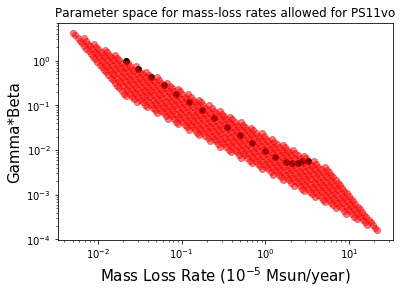

In [23]:
file_in = 'PS11vo_ParameterSpace.csv'
data_plot = ascii.read(file_in)

gammabeta = data_plot['v_shock']*(1/3e5)



plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(data_plot['Mdot'][i],gammabeta[i],'ro',alpha=0.5)
    else:
        plt.plot(data_plot['Mdot'][i],gammabeta[i],'ko')# label ='PS11aop8')#,alpha=0.2)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Mass Loss Rate ($10^{-5}$ Msun/year)',fontsize =15)
plt.ylabel('Gamma*Beta',fontsize =15)
plt.title('Parameter space for mass-loss rates allowed for PS11vo')
#plt.show()
plt.savefig('mg8PS11vo.pdf')

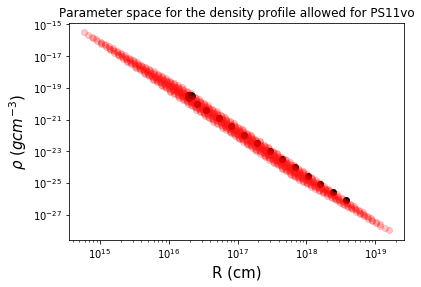

In [24]:
file_in = 'PS11vo_ParameterSpace.csv'
data_plot = ascii.read(file_in)
R = data_plot['Radius']
#gammabeta = data_plot['v_shock']*(1/3e5)



plt.figure()

for i in range(len(data_plot)):
    if data_plot['RuledOut'][i] == 'True':
        plt.plot(R[i],data_plot['den'][i],'ro',alpha=0.2)
    else:
        plt.plot(R[i],data_plot['den'][i],'ko')# label ='PS11aop8')#,alpha=0.2)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'R (cm)',fontsize =15)
plt.ylabel(r'$\rho$ ($gcm^{-3}$)',fontsize =15)
plt.title('Parameter space for the density profile allowed for PS11vo')
#plt.show()
plt.savefig('PS11vodr.pdf')

/home/ibik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


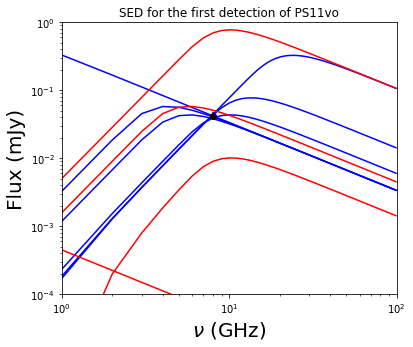

In [33]:
#for the detection
data = pd.read_csv('/home/ibik/PS11vo_ParameterSpace.csv')

F_nup1 = data['F_peak'][0] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p1 = data['nu_peak'][0]#.take([0, 3, 14])#[3,5,6])
R1 = data['Radius'][0]#.take([0, 3, 14]) #[3,5,6])
M1 = data['Mdot'][0]#.take([0, 3, 14])

t=t_p =  1430.323297 # time of observation in days
D = 543.4 # distance to SN in Mpc
m = 0.88 #using stAandard model
p = 3.0 #using standard model
a = (2*m)+0.5
b = (p+5-(6*m))/2
nu =np.arange(1, 100, dtype=float)
        #calculate SSA
SSA_sed1 = F_nup1*1.582*(t/t_p)**a*(nu/nu_p1)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p1)**(-(p+4)/2)))           
#Correct SED for FFA:
Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 

M_cgs1 =  M1 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff1 = 2.021e25*M_cgs1**2*Z_ave/(miu**2*nu**(2.1)*R1**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed1 = SSA_sed1*np.exp(-tau_ff1)

F_nup2 = data['F_peak'][2] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p2 = data['nu_peak'][2]#.take([0, 3, 14])#[3,5,6])
R2 = data['Radius'][2]#.take([0, 3, 14]) #[3,5,6])
M2 = data['Mdot'][2]#.take([0, 3, 14])
SSA_sed2 = F_nup2*1.582*(t/t_p)**a*(nu/nu_p2)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p2)**(-(p+4)/2)))    
M_cgs2 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff2 = 2.021e25*M_cgs2**2*Z_ave/(miu**2*nu**(2.1)*R2**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed2 = SSA_sed2*np.exp(-tau_ff2)

F_nup3 = data['F_peak'][3] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p3 = data['nu_peak'][3]#.take([0, 3, 14])#[3,5,6])
R3 = data['Radius'][3]#.take([0, 3, 14]) #[3,5,6])
M3 = data['Mdot'][3]#.take([0, 3, 14])
SSA_sed3 = F_nup3*1.582*(t/t_p)**a*(nu/nu_p3)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p3)**(-(p+4)/2)))    
M_cgs3 =  M3 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff3 = 2.021e25*M_cgs3**2*Z_ave/(miu**2*nu**(2.1)*R3**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed3 = SSA_sed3*np.exp(-tau_ff3)

F_nup4 = data['F_peak'][5] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p4 = data['nu_peak'][5]#.take([0, 3, 14])#[3,5,6])
R4 = data['Radius'][5]#.take([0, 3, 14]) #[3,5,6])
M4 = data['Mdot'][5]#.take([0, 3, 14])
SSA_sed4 = F_nup4*1.582*(t/t_p)**a*(nu/nu_p4)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p4)**(-(p+4)/2)))    
M_cgs4 =  M4 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff4 = 2.021e25*M_cgs4**2*Z_ave/(miu**2*nu**(2.1)*R4**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed4 = SSA_sed4*np.exp(-tau_ff4)

F_nup5 = data['F_peak'][12] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p5 = data['nu_peak'][12]#.take([0, 3, 14])#[3,5,6])
R5 = data['Radius'][12]#.take([0, 3, 14]) #[3,5,6])
M5 = data['Mdot'][12]#.take([0, 3, 14])
SSA_sed5 = F_nup5*1.582*(t/t_p)**a*(nu/nu_p5)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p5)**(-(p+4)/2)))    
M_cgs5 =  M5 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff5 = 2.021e25*M_cgs5**2*Z_ave/(miu**2*nu**(2.1)*R5**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed5 = SSA_sed5*np.exp(-tau_ff5)

F_nup6 = data['F_peak'][14] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p6 = data['nu_peak'][14]#.take([0, 3, 14])#[3,5,6])
R6 = data['Radius'][14]#.take([0, 3, 14]) #[3,5,6])
M6 = data['Mdot'][14]#.take([0, 3, 14])
SSA_sed6 = F_nup6*1.582*(t/t_p)**a*(nu/nu_p6)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p6)**(-(p+4)/2)))    
M_cgs6 =  M2 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff6 = 2.021e25*M_cgs6**2*Z_ave/(miu**2*nu**(2.1)*R6**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed6 = SSA_sed6*np.exp(-tau_ff6)

F_nup7 = data['F_peak'][380] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p7 = data['nu_peak'][380]#.take([0, 3, 14])#[3,5,6])
R7 = data['Radius'][380]#.take([0, 3, 14]) #[3,5,6])
M7 = data['Mdot'][380]#.take([0, 3, 14])
SSA_sed7 = F_nup7*1.582*(t/t_p)**a*(nu/nu_p7)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p7)**(-(p+4)/2)))    
M_cgs7 =  M7 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff7 = 2.021e25*M_cgs7**2*Z_ave/(miu**2*nu**(2.1)*R7**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed7 = SSA_sed7*np.exp(-tau_ff7)

F_nup8 = data['F_peak'][594] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p8 = data['nu_peak'][594]#.take([0, 3, 14])#[3,5,6])
R8 = data['Radius'][594]#.take([0, 3, 14]) #[3,5,6])
M8 = data['Mdot'][594]#.take([0, 3, 14])
SSA_sed8 = F_nup8*1.582*(t/t_p)**a*(nu/nu_p8)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p8)**(-(p+4)/2)))    
M_cgs8 =  M8 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff8 = 2.021e25*M_cgs8**2*Z_ave/(miu**2*nu**(2.1)*R8**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed8 = SSA_sed8*np.exp(-tau_ff8)

F_nup9 = data['F_peak'][236] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p9 = data['nu_peak'][236]#.take([0, 3, 14])#[3,5,6])
R9 = data['Radius'][236]#.take([0, 3, 14]) #[3,5,6])
M9 = data['Mdot'][236]#.take([0, 3, 14])
SSA_sed9 = F_nup9*1.582*(t/t_p)**a*(nu/nu_p9)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p9)**(-(p+4)/2)))    
M_cgs9 =  M9 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff9 = 2.021e25*M_cgs9**2*Z_ave/(miu**2*nu**(2.1)*R9**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed9 = SSA_sed9*np.exp(-tau_ff9)


F_nup10 = data['F_peak'][168] #.take([0, 3, 14])#data['F_peak'][3,5,6])
nu_p10 = data['nu_peak'][168]#.take([0, 3, 14])#[3,5,6])
R10 = data['Radius'][168]#.take([0, 3, 14]) #[3,5,6])
M10 = data['Mdot'][168]#.take([0, 3, 14])
SSA_sed10 = F_nup10*1.582*(t/t_p)**a*(nu/nu_p10)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu/nu_p10)**(-(p+4)/2)))    
M_cgs10 =  M10 * 1e-5 * 6.307e+25 #mass loss rate in cgs units
tau_ff10 = 2.021e25*M_cgs10**2*Z_ave/(miu**2*nu**(2.1)*R10**3*vw_cgs**2*T**(1.35))   
SSA_FFA_sed10 = SSA_sed10*np.exp(-tau_ff10)


plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 10})
plt.autoscale()
plt.xscale('log')
plt.yscale('log')
ax=plt.subplot(111)
yerr = 0.0053
plt.ylim(10**(-4),1)
plt.xlim(1,100)
#plt.errorbar(6,0.0318,yerr,fmt ='o')#'ro', markersize=10)
plt.plot(nu,SSA_FFA_sed1,'b', nu,SSA_FFA_sed2,'b',nu,SSA_FFA_sed3,'b',nu,SSA_FFA_sed4,'b',nu,SSA_FFA_sed5,'b',nu,SSA_FFA_sed6,'b',nu,SSA_FFA_sed7,'r',nu,SSA_FFA_sed8,'r',nu,SSA_FFA_sed9,'r',nu,SSA_FFA_sed10,'r',label ='PS11aop8')
plt.errorbar(8,0.0418,yerr,fmt ='ko')
#plt.plot(8, 0.0418, 'ko', markersize=10)
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) #Log$_{10}$ Luminosity (erg $s^{-1}$ $Hz^{-1}$)', fontsize =14)

        #plt.show()
plt.title('SED for the first detection of PS11vo')   
plt.savefig('PS11vosed.pdf')


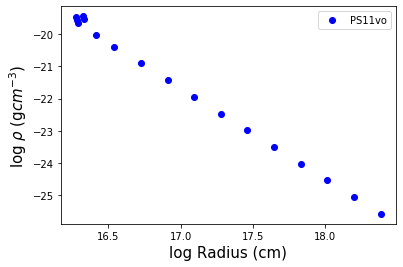

In [32]:
data = pd.read_csv('/home/ibik/PS11vo_ParameterSpace.csv')

R1 = data['Radius']#.take([0, 3, 14]) #[3,5,6])
#a =data['A']
den = data['den']

plt.figure(1)
plt.plot(np.log10(R1[0:17]),np.log10(den[0:17]),'bo',label = 'PS11vo')
#plt.plot(R1[0:17],den[0:17],'bo',label = 'PS11vo')


#plt.plot(np.log10(data['Radius'][0:8]),np.log10(data['den'][0:8]),'bo',np.log10(data['Radius'][9]),np.log10(data['densityw'][9]),'ko')


plt.xlabel('log Radius (cm)',fontsize =15)
plt.ylabel(r'log $\rho$ (g$cm^{-3}$)', fontsize =15)
plt.legend()
#plt.show()
plt.savefig('dppss11vo.pdf')
